<a href="https://colab.research.google.com/github/cgurkan/fake-news/blob/main/FakeNewsDetection_LSTMandGloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detection

- Preprocess
- Build Model With CNN and LSTM using pretrained word embeddings

# Import Libraries

In [1]:
import sys
import math
import pandas as pd
import numpy as np

import nltk
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import word_tokenize
from nltk.corpus import names ,wordnet, stopwords
from unicodedata import category

#Data Visualisation

import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go 

#Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest,chi2, f_classif
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import classification_report , confusion_matrix, accuracy_score, f1_score, roc_curve
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

#Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import one_hot, Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding, Input, LSTM, Conv1D, MaxPool1D, Bidirectional,Activation, Dropout,GlobalMaxPool1D, Conv1D
from keras.models import Model
from keras.utils import pad_sequences, plot_model
from keras import utils
from keras.optimizers import Adam

# Dataset

In [2]:
# Google Drive is used for to store unprocessed/processed dataset 
BASE_URL = "/content/drive/MyDrive/Colab Notebooks/fakenews/"
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Preprocessed data location
training_path = BASE_URL + 'data/processed/fakenews_training_processed.csv'
test_path = BASE_URL + 'data/processed/fakenews_test_processed.csv'

# Read Training Dataset
df = pd.read_csv(training_path)
df.head()

,Unnamed: 0,label,label_name,title_text
0,0,0,False,fin currency passenger use mobile phone start ...
1,1,2,Partially False,missouri lawmaker condemn la vega shoot missou...
2,2,2,Partially False,cbc cut donald trump home alone number cameo b...
3,3,0,False,obamas daughter caught camera burning u flag d...
4,4,0,False,leak visitor log reveal schiffs number visit e...


In [4]:
# Read Test  Dataset ( will be merged with Training Dataset)
df_test = pd.read_csv(test_path)
df_test.head()

,Unnamed: 0,label,label_name,title_text
0,0,2,Partially False,u treasury deputy sec warns shortage likely co...
1,1,3,Other,cnn praise taliban wear mask attack kabulappro...
2,2,0,False,tennessee legalize government covid kidnapping...
3,3,0,False,medical shocker scientist sloan kettering disc...
4,4,0,False,study result facemasks ineffective block trans...


# Utility Functions

Some utiltiy functions such as 
- learning curve finder
- plot the learning curve
- print confusion matrix,

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
from PIL import Image
import sklearn as sklearn
from sklearn.metrics import confusion_matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier as MLPC
from sklearn import model_selection
import tensorflow as tf
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras import initializers, layers, models
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras.utils.vis_utils import plot_model


def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()


# Extracted from https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search
import matplotlib.pyplot as plt
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
  

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)


def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

dict_characters = {0: '0', 1: '1', 2: '2', 
        3: '3', 4: '4', 5: '5', 6: '6', 7:'7',
        8: '8', 9: '9'}

from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
import keras.backend as K


class LRFinder:
    """
    Plots the change of the loss function of a Keras model when the learning rate is exponentially increasing.
    See for details:
    https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
    """
    def __init__(self, model):
        self.model = model
        self.losses = []
        self.lrs = []
        self.best_loss = 1e9

    def on_batch_end(self, batch, logs):
        # Log the learning rate
        lr = K.get_value(self.model.optimizer.lr)
        self.lrs.append(lr)

        # Log the loss
        loss = logs['loss']
        self.losses.append(loss)

        # Check whether the loss got too large or NaN
        if math.isnan(loss) or loss > self.best_loss * 4:
            self.model.stop_training = True
            return

        if loss < self.best_loss:
            self.best_loss = loss

        # Increase the learning rate for the next batch
        lr *= self.lr_mult
        K.set_value(self.model.optimizer.lr, lr)

    def find(self, x_train, y_train, start_lr, end_lr, batch_size=64, epochs=1):
        num_batches = epochs * x_train.shape[0] / batch_size
        self.lr_mult = (end_lr / start_lr) ** (1 / num_batches)

        # Save weights into a file
        self.model.save_weights('tmp.h5')

        # Remember the original learning rate
        original_lr = K.get_value(self.model.optimizer.lr)

        # Set the initial learning rate
        K.set_value(self.model.optimizer.lr, start_lr)

        callback = LambdaCallback(on_batch_end=lambda batch, logs: self.on_batch_end(batch, logs))

        self.model.fit(x_train, y_train,
                        batch_size=batch_size, epochs=epochs,
                        callbacks=[callback])

        # Restore the weights to the state before model fitting
        self.model.load_weights('tmp.h5')

        # Restore the original learning rate
        K.set_value(self.model.optimizer.lr, original_lr)

    def plot_loss(self, n_skip_beginning=10, n_skip_end=5):
        """
        Plots the loss.
        Parameters:
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
        """
        plt.ylabel("loss")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], self.losses[n_skip_beginning:-n_skip_end])
        plt.xscale('log')

    def plot_loss_change(self, sma=1, n_skip_beginning=10, n_skip_end=5, y_lim=(-0.01, 0.01)):
        """
        Plots rate of change of the loss function.
        Parameters:
            sma - number of batches for simple moving average to smooth out the curve.
            n_skip_beginning - number of batches to skip on the left.
            n_skip_end - number of batches to skip on the right.
            y_lim - limits for the y axis.
        """
        assert sma >= 1
        derivatives = [0] * sma
        for i in range(sma, len(self.lrs)):
            derivative = (self.losses[i] - self.losses[i - sma]) / sma
            derivatives.append(derivative)

        plt.ylabel("rate of loss change")
        plt.xlabel("learning rate (log scale)")
        plt.plot(self.lrs[n_skip_beginning:-n_skip_end], derivatives[n_skip_beginning:-n_skip_end])
        plt.xscale('log')
        plt.ylim(y_lim)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

# Feature Extraction

## Tokenizer

In [7]:
nltk.download('punkt')

# The Total unique Words In The Dataset
list_of_words = []
for doc in df.title_text:
  tokens = nltk.word_tokenize(doc)
  for j in tokens:
    list_of_words.append(j)

# Obtaining The Total Number Of Unique Words
total_words = len(list(set(list_of_words)))
total_words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


24293

In [13]:
maxlen = -1
for doc in df.title_text:
    tokens = nltk.word_tokenize(doc)
    if(maxlen<len(tokens)):
        maxlen = len(tokens)
print("The maximum number of words in any document is =", maxlen)

The maximum number of words in any document is = 3614


In [9]:
#Split dataset
x_train,x_test,y_train,y_test = df.title_text, df_test.title_text, df.label, df_test.label

In [18]:
# Creating A Tokenizer To Tokenize The Words And Create Sequences Of Tokenized Words
tokenizer = Tokenizer(num_words = total_words)
tokenizer.fit_on_texts(x_train)

train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

vocab_size = len(tokenizer.word_index) + 1  
print(vocab_size)
print(total_words)

24269
24293


In [19]:
#maxlen=1250
# Adding Padding
padded_train = pad_sequences(train_sequences ,maxlen = maxlen, padding='post')
padded_test = pad_sequences(test_sequences, maxlen = maxlen,padding='post') 

## Embedding (Pretrained)

In [12]:
# Download Pretrained word embeddings (GloVe 6Billion)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2023-06-11 08:04:05--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-06-11 08:04:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-06-11 08:04:06--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [106]:
def embedding_for_vocab(filepath, word_index,
                        embedding_dim):
    vocab_size = len(word_index) + 1
      
    # Adding again 1 because of reserved 0 index
    embedding_matrix_vocab = np.zeros((vocab_size,
                                       embedding_dim))
  
    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
  
    return embedding_matrix_vocab
 
# matrix for vocab: word_index



In [46]:
#USing 100 dimension
embedding_dim = 100
embedding_matrix_vocab = embedding_for_vocab('glove.6B.100d.txt', tokenizer.word_index, embedding_dim)

# Building Model

## LSTM

In [155]:
from tensorflow.keras import backend as K

def myf1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [159]:
model5 = Sequential()
model5.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen, weights = [embedding_matrix_vocab], trainable = False))
model5.add(Bidirectional(LSTM(32)))
#model5.add(Dense(32, activation='relu'))
model5.add(Dropout(0.3))
model5.add(Dense(32, activation='relu'))
model5.add(Dropout(0.2))
model5.add(Dense(4, activation='softmax'))
#Adam(learning_rate=0.01)
model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
model5.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_24 (Embedding)    (None, 3614, 100)         2426900   
                                                                 
 bidirectional_24 (Bidirecti  (None, 64)               34048     
 onal)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 64)                0         
                                                                 
 dense_30 (Dense)            (None, 32)                2080      
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_31 (Dense)            (None, 4)                 132       
                                                     

Epoch 1/20
10/10 [==============================] - 2s 169ms/step - loss: 1.1151 - accuracy: 0.5000
Epoch 2/20
10/10 [==============================] - 2s 166ms/step - loss: 1.1150 - accuracy: 0.5206
Epoch 3/20
10/10 [==============================] - 2s 166ms/step - loss: 1.1211 - accuracy: 0.5008
Epoch 4/20
10/10 [==============================] - 2s 166ms/step - loss: 1.1191 - accuracy: 0.5047
Epoch 5/20
10/10 [==============================] - 2s 168ms/step - loss: 1.1030 - accuracy: 0.5182
Epoch 6/20
10/10 [==============================] - 2s 189ms/step - loss: 1.0904 - accuracy: 0.5316
Epoch 7/20
10/10 [==============================] - 2s 198ms/step - loss: 1.0698 - accuracy: 0.5435
Epoch 8/20
10/10 [==============================] - 2s 166ms/step - loss: 1.0514 - accuracy: 0.5372
Epoch 9/20
10/10 [==============================] - 2s 168ms/step - loss: 1.0432 - accuracy: 0.5483
Epoch 10/20
10/10 [==============================] - 2s 167ms/step - loss: 0.9974 - accuracy: 0.5791

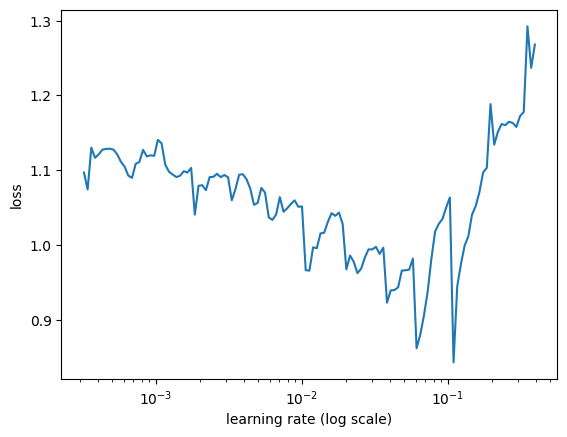

In [88]:
lr_finder = LRFinder(model5)
lr_finder.find(padded_train, y_train, start_lr=0.0001, end_lr=10, batch_size=128, epochs=20)
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)
plt.show()

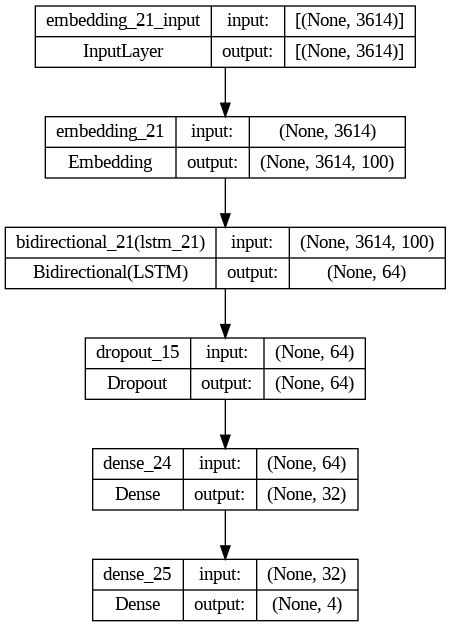

In [141]:
plot_model(model5, to_file='model_1.png', show_shapes=True, show_layer_names=True)

In [167]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3)
mc = tf.keras.callbacks.ModelCheckpoint(
    filepath='model5.h5',    
    monitor='val_accuracy',    
    mode='max',
    save_best_only=True,
    verbose=1)
epoch=20
history5 = model5.fit(padded_train, y_train,
                    batch_size=128,
                    epochs=epoch,
                    validation_data=(padded_test, y_test),                    
                    callbacks = [es,mc]
                    ) 

Epoch 1/20
10/10 [==============================] - ETA: 0s - loss: 1.1472 - sparse_categorical_accuracy: 0.5008

10/10 [==============================] - 2s 240ms/step - loss: 1.1472 - sparse_categorical_accuracy: 0.5008 - val_loss: 1.2176 - val_sparse_categorical_accuracy: 0.5016
Epoch 2/20
10/10 [==============================] - ETA: 0s - loss: 1.1429 - sparse_categorical_accuracy: 0.4976

10/10 [==============================] - 3s 274ms/step - loss: 1.1429 - sparse_categorical_accuracy: 0.4976 - val_loss: 1.2232 - val_sparse_categorical_accuracy: 0.5082
Epoch 3/20
10/10 [==============================] - ETA: 0s - loss: 1.1333 - sparse_categorical_accuracy: 0.5016

10/10 [==============================] - 2s 208ms/step - loss: 1.1333 - sparse_categorical_accuracy: 0.5016 - val_loss: 1.2151 - val_sparse_categorical_accuracy: 0.5065
Epoch 4/20
10/10 [==============================] - ETA: 0s - loss: 1.1289 - sparse_categorical_accuracy: 0.5079

10/10 [==============================] - 2s 208ms/step - loss: 1.1289 - sparse_categorical_accuracy: 0.5079 - val_loss: 1.2178 - val_sparse_categorical_accuracy: 0.5033
Epoch 5/20
10/10 [==============================] - ETA: 0s - loss: 1.1140 - sparse_categorical_accuracy: 0.5071

10/10 [==============================] - 2s 237ms/step - loss: 1.1140 - sparse_categorical_accuracy: 0.5071 - val_loss: 1.2439 - val_sparse_categorical_accuracy: 0.5082
Epoch 6/20
10/10 [==============================] - ETA: 0s - loss: 1.0859 - sparse_categorical_accuracy: 0.5229

10/10 [==============================] - 2s 237ms/step - loss: 1.0859 - sparse_categorical_accuracy: 0.5229 - val_loss: 1.2366 - val_sparse_categorical_accuracy: 0.4853


In [168]:
model = keras.models.load_model('model5.h5')

loss, accuracy = model.evaluate(padded_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(padded_test,y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.4937
Testing Accuracy:  0.5033


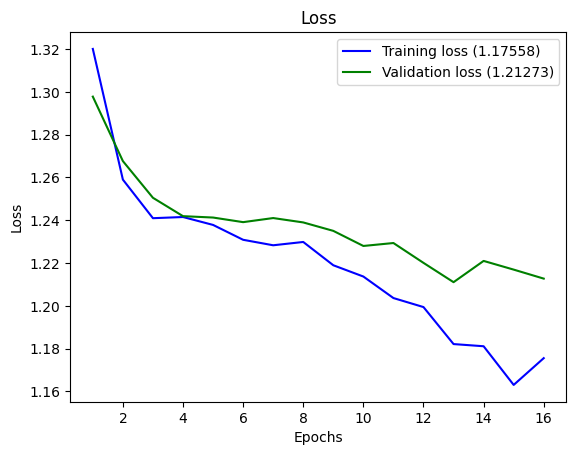

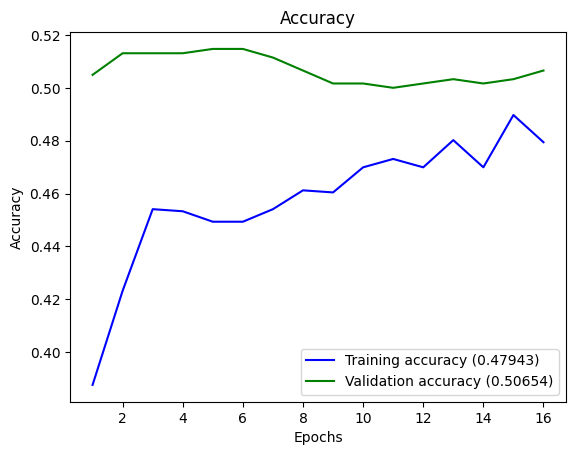

In [162]:
plot_history(history5)

In [169]:
#Evaluation
y_prediction_5 = model.predict(padded_test)
y_prediction_5 = np.argmax (y_prediction_5, axis = 1)
result_5 = confusion_matrix(y_test, y_prediction_5)

20/20 [==============================] - 3s 88ms/step


In [170]:
#Print Classification Report
print(classification_report(y_test, y_prediction_5, zero_division=1))

              precision    recall  f1-score   support

           0       0.53      0.97      0.68       315
           1       1.00      0.00      0.00       210
           2       0.12      0.07      0.09        56
           3       1.00      0.00      0.00        31

    accuracy                           0.50       612
   macro avg       0.66      0.26      0.19       612
weighted avg       0.68      0.50      0.36       612



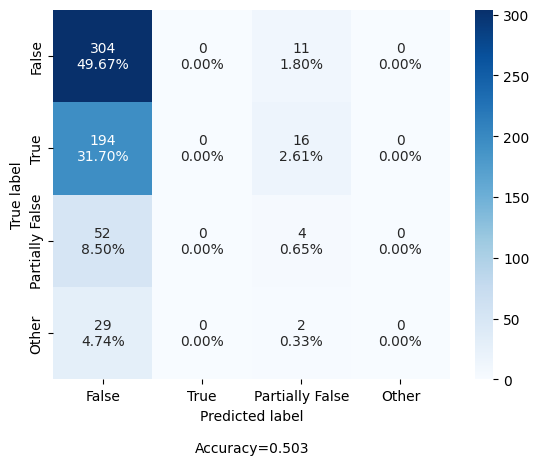

In [171]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['False', 'True', 'Partially False', 'Other']

make_confusion_matrix(result_5, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',
                      #figsize=(5,5),
                      cbar=True, 
                      #title='Confusion Matrix: Model 5',
                      #sum_stats=True
                      )